In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-gan-competition/shard_02/data.jsonl
/kaggle/input/test-gan-competition/shard_45/data.jsonl
/kaggle/input/test-gan-competition/shard_09/data.jsonl
/kaggle/input/test-gan-competition/shard_37/data.jsonl
/kaggle/input/test-gan-competition/shard_35/data.jsonl
/kaggle/input/test-gan-competition/shard_15/data.jsonl
/kaggle/input/test-gan-competition/shard_31/data.jsonl
/kaggle/input/test-gan-competition/shard_50/data.jsonl
/kaggle/input/test-gan-competition/shard_20/data.jsonl
/kaggle/input/test-gan-competition/shard_25/data.jsonl
/kaggle/input/test-gan-competition/shard_46/data.jsonl
/kaggle/input/test-gan-competition/shard_39/data.jsonl
/kaggle/input/test-gan-competition/shard_40/data.jsonl
/kaggle/input/test-gan-competition/shard_44/data.jsonl
/kaggle/input/test-gan-competition/shard_33/data.jsonl
/kaggle/input/test-gan-competition/shard_59/data.jsonl
/kaggle/input/test-gan-competition/shard_53/data.jsonl
/kaggle/input/test-gan-competition/shard_54/data.jsonl
/kaggle/in

## 1. Imports + config + decode function

In [2]:
import base64, io, json, os
from glob import glob

import numpy as np
from PIL import Image, ImageOps, ImageFile, UnidentifiedImageError

ImageFile.LOAD_TRUNCATED_IMAGES = True  # tolerate truncated images


def get_img_b64(rec):
    """
    Simple, explicit key lookup for the main image.
    """
    for k in ["img_b64", "img64", "img_64"]:
        v = rec.get(k)
        if isinstance(v, str) and v.strip():
            return v.strip()
    return None


def b64_to_bytes(s: str) -> bytes:
    """
    Base64 decode with only padding fix.
    """
    s = s.strip()
    missing = (-len(s)) % 4
    if missing:
        s += "=" * missing
    return base64.b64decode(s)


def decode_record_to_image(rec):
    """
    Minimal, spec-following decoder:

      1. Base64 -> bytes (from img_b64/img64/img_64)
      2. Open with PIL
      3. Apply EXIF rotation and inversion
      4. Handle alpha (built-in RGBA) by compositing on white
      5. Convert to RGB
      6. Resize to 32x32

    Returns a 32x32 RGB PIL.Image or None on failure.
    """
    try:
        # 1. Decode Base64 -> bytes
        b64 = get_img_b64(rec)
        if b64 is None:
            return None

        try:
            img_bytes = b64_to_bytes(b64)
        except Exception:
            return None

        # 2. Open using PIL
        try:
            bio = io.BytesIO(img_bytes)
            img = Image.open(bio)
            img.load()
        except (UnidentifiedImageError, OSError):
            return None

        mode_field = rec.get("mode", img.mode)
        exif_rot = rec.get("exif_rot", 0)
        invert_flag = rec.get("invert", False)

        # 3. EXIF rotation
        if exif_rot:
            img = img.rotate(exif_rot, expand=True)

        # Basic mode handling, including I;16
        if mode_field == "I;16" or img.mode == "I;16":
            # convert 16-bit array to 8-bit with a simple rescale
            arr = np.array(img, dtype=np.uint16)
            vmax = arr.max()
            if vmax > 0:
                arr8 = (arr.astype(np.float32) / vmax * 255.0).astype(np.uint8)
            else:
                arr8 = np.zeros_like(arr, dtype=np.uint8)
            img = Image.fromarray(arr8, mode="L")
        elif mode_field == "RGBA":
            img = img.convert("RGBA")

        # Inversion (on 8-bit)
        if invert_flag:
            img = img.convert("L")
            img = ImageOps.invert(img)

        # 4. Handle alpha channels if present (built-in only)
        if img.mode == "RGBA":
            bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
            img = Image.alpha_composite(bg, img)
            img = img.convert("RGB")

        # 5. Convert to RGB
        if img.mode == "L":
            img = img.convert("RGB")
        elif img.mode != "RGB":
            img = img.convert("RGB")

        # 6. Resize to 32×32
        img = img.resize((32, 32), resample=Image.BICUBIC)

        return img

    except Exception:
        return None

## 2. Iterate over shards & save PNGs

In [3]:
INPUT_ROOT = "/kaggle/input/test-gan-competition"
OUT_ROOT = "/kaggle/working/train_images"
OUT_CLASS_DIR = os.path.join(OUT_ROOT, "all")  # ImageFolder expects subfolders

os.makedirs(OUT_CLASS_DIR, exist_ok=True)

In [4]:
import shutil
from tqdm.auto import tqdm

if os.path.exists(OUT_CLASS_DIR):
    shutil.rmtree(OUT_CLASS_DIR)
os.makedirs(OUT_CLASS_DIR, exist_ok=True)
print("OUT_CLASS_DIR reset:", OUT_CLASS_DIR)

jsonl_paths = sorted(glob(os.path.join(
    "/kaggle/input/test-gan-competition", "shard_*", "data.jsonl"
)))
print("Found shards:", len(jsonl_paths))

num_saved = 0
num_failed = 0

for jsonl_path in jsonl_paths:
    print("Processing", jsonl_path)
    with open(jsonl_path, "r") as f:
        for line in tqdm(f, mininterval=1.0, leave=False):
            line = line.strip()
            if not line:
                continue
            try:
                rec = json.loads(line)
            except json.JSONDecodeError:
                num_failed += 1
                continue

            img = decode_record_to_image(rec)
            if img is None:
                num_failed += 1
                continue

            img_id = rec.get("id")
            if not img_id:
                num_failed += 1
                continue

            out_path = os.path.join(OUT_CLASS_DIR, f"{img_id}.png")
            if not os.path.exists(out_path):
                img.save(out_path)
                num_saved += 1

print("Saved images :", num_saved)
print("Failed records:", num_failed)

OUT_CLASS_DIR reset: /kaggle/working/train_images/all
Found shards: 60
Processing /kaggle/input/test-gan-competition/shard_00/data.jsonl


0it [00:00, ?it/s]

/tmp/ipykernel_48/2165087500.py:81: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(arr8, mode="L")


Processing /kaggle/input/test-gan-competition/shard_01/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_02/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_03/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_04/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_05/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_06/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_07/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_08/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_09/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_10/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_11/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_12/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_13/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_14/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_15/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_16/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_17/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_18/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_19/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_20/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_21/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_22/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_23/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_24/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_25/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_26/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_27/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_28/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_29/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_30/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_31/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_32/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_33/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_34/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_35/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_36/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_37/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_38/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_39/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_40/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_41/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_42/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_43/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_44/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_45/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_46/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_47/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_48/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_49/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_50/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_51/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_52/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_53/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_54/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_55/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_56/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_57/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_58/data.jsonl


0it [00:00, ?it/s]

Processing /kaggle/input/test-gan-competition/shard_59/data.jsonl


0it [00:00, ?it/s]

Saved images : 58852
Failed records: 1148


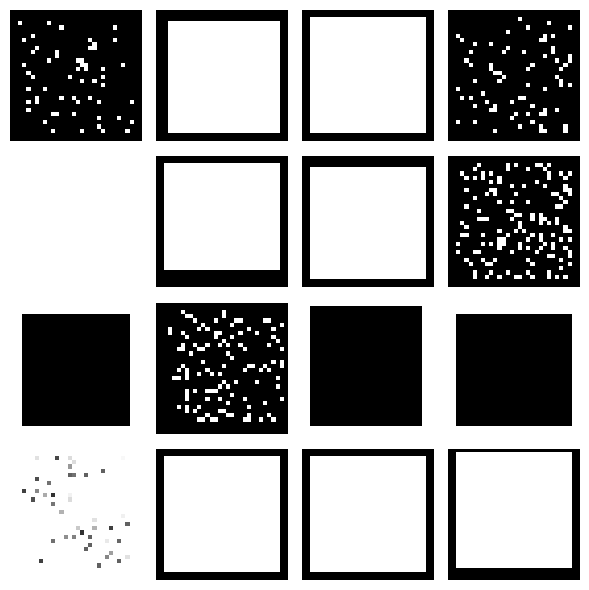

In [5]:
from glob import glob
import matplotlib.pyplot as plt
from PIL import Image

sample_paths = sorted(glob(os.path.join(OUT_CLASS_DIR, "*.png")))[:16]
plt.figure(figsize=(6, 6))
for i, p in enumerate(sample_paths):
    img = Image.open(p)
    plt.subplot(4, 4, i + 1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [6]:
import os
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from tqdm.auto import tqdm

# adjust if your path is different
OUT_ROOT = "/kaggle/working/train_images"
OUT_CLASS_DIR = os.path.join(OUT_ROOT, "all")

IMG_DIR = OUT_CLASS_DIR
paths = sorted(glob(os.path.join(IMG_DIR, "*.png")))
print("Total decoded PNGs found:", len(paths))

rows = []
for p in tqdm(paths):
    img = Image.open(p).convert("L")   # grayscale for stats
    arr = np.array(img, dtype=np.float32) / 255.0

    mean = float(arr.mean())
    std  = float(arr.std())
    min_v = float(arr.min())
    max_v = float(arr.max())
    frac_near0 = float((arr < 0.02).mean())   # fraction very dark
    frac_near1 = float((arr > 0.98).mean())   # fraction very bright

    rows.append({
        "path": p,
        "mean": mean,
        "std": std,
        "min": min_v,
        "max": max_v,
        "frac_near0": frac_near0,
        "frac_near1": frac_near1,
    })

stats_df = pd.DataFrame(rows)
stats_df.to_csv("image_stats.csv", index=False)
print("Saved stats to image_stats.csv")
stats_df.describe()

Total decoded PNGs found: 58852


  0%|          | 0/58852 [00:00<?, ?it/s]

Saved stats to image_stats.csv


,mean,std,min,max,frac_near0,frac_near1
count,58852.000000,58852.000000,58852.000000,58852.0,58852.000000,58852.000000
mean,0.421228,0.353278,0.027286,1.0,0.571684,0.416954
std,0.325246,0.108727,0.113239,0.0,0.331394,0.320583
min,0.027344,0.000000,0.000000,1.0,0.000000,0.027344
25%,0.104492,0.285958,0.000000,1.0,0.261719,0.104492
50%,0.288086,0.405178,0.000000,1.0,0.710938,0.280273
75%,0.738281,0.439570,0.000000,1.0,0.895508,0.738281
max,1.000000,0.499355,1.000000,1.0,0.972656,1.000000


## Define a first-pass “bad image” rule

In [7]:
# Heuristic filters for almost-blank / almost-constant images
blankish = (
    (stats_df["std"] < 0.02) |
    (stats_df["mean"] < 0.01) |
    (stats_df["mean"] > 0.99) |
    (stats_df["frac_near0"] > 0.98) |
    (stats_df["frac_near1"] > 0.98)
)

print("Blank-ish images flagged:", blankish.sum(), "out of", len(stats_df))

clean_df = stats_df[~blankish].reset_index(drop=True)
print("Remaining (clean) images:", len(clean_df))

Blank-ish images flagged: 756 out of 58852
Remaining (clean) images: 58096


## Copy filtered images into a clean dataset folder

In [8]:
import shutil

CLEAN_ROOT = "/kaggle/working/train_images_clean"
CLEAN_DIR  = os.path.join(CLEAN_ROOT, "all")

# reset clean directory
if os.path.exists(CLEAN_ROOT):
    shutil.rmtree(CLEAN_ROOT)

os.makedirs(CLEAN_DIR, exist_ok=True)

for p in tqdm(clean_df["path"], desc="Copying clean images"):
    fname = os.path.basename(p)
    dst = os.path.join(CLEAN_DIR, fname)
    shutil.copy2(p, dst)

print("Copied", len(clean_df), "images to", CLEAN_DIR)

Copying clean images:   0%|          | 0/58096 [00:00<?, ?it/s]

Copied 58096 images to /kaggle/working/train_images_clean/all


## Pack cleaned images into a .npy array for fast loading

In [9]:
import os
import numpy as np
from glob import glob
from PIL import Image
from tqdm.auto import tqdm

CLEAN_ROOT = "/kaggle/working/train_images_clean"
CLEAN_DIR  = os.path.join(CLEAN_ROOT, "all")

paths = sorted(glob(os.path.join(CLEAN_DIR, "*.png")))
print("Clean PNGs found:", len(paths))

# We'll store as uint8 [0..255], CHW format
N = len(paths)
arr = np.empty((N, 3, 32, 32), dtype=np.uint8)

for i, p in enumerate(tqdm(paths)):
    img = Image.open(p).convert("RGB")
    img = img.resize((32, 32), Image.BICUBIC)  # should already be 32x32, but safe
    x = np.array(img, dtype=np.uint8)          # H,W,3
    x = np.transpose(x, (2, 0, 1))             # 3,H,W
    arr[i] = x

np.save("clean_images_uint8.npy", arr)
print("Saved clean_images_uint8.npy with shape:", arr.shape)

Clean PNGs found: 58096


  0%|          | 0/58096 [00:00<?, ?it/s]

Saved clean_images_uint8.npy with shape: (58096, 3, 32, 32)


## DataLoader on the cleaned-Fast Dataset with [-1, 1] normalization

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class NpyImageDataset(Dataset):
    def __init__(self, npy_path):
        # memmap for speed & low RAM
        self.data = np.load(npy_path, mmap_mode="r")  # shape (N,3,32,32), uint8

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        x = self.data[idx].astype(np.float32)  # (3,32,32) in [0..255]
        x = x / 127.5 - 1.0                    # -> [-1,1]
        x = torch.from_numpy(x)               # torch.float32
        y = 0                                  # dummy label (unused for GAN)
        return x, y

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

dataset = NpyImageDataset("clean_images_uint8.npy")
loader = DataLoader(
    dataset,
    batch_size=128,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
)

print("Dataset size:", len(dataset))

Device: cuda
Dataset size: 58096


## Model- Generator + Discriminator with no normalization

In [11]:
import torch.nn as nn

nz  = 128
ngf = 64
ndf = 64
nc  = 3

class Generator(nn.Module):
    def __init__(self, nz=nz, ngf=ngf, nc=nc):
        super().__init__()
        self.net = nn.Sequential(
            # input: (nz,1,1)
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),  # 4x4
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),  # 8x8
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),      # 16x16
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),           # 32x32
            nn.Tanh(),  # outputs in [-1,1]
        )

    def forward(self, z):
        return self.net(z)


class Critic(nn.Module):
    """
    WGAN-GP critic with:
      - Conv layers
      - NO normalization (no BatchNorm, no InstanceNorm)
    """
    def __init__(self, ndf=ndf, nc=nc):
        super().__init__()
        self.net = nn.Sequential(
            # input: (nc, 32, 32)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),       # 16x16
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),  # 8x8
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),  # 4x4
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),    # 1x1
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1)   # (batch,)

In [12]:
G = Generator(nz=nz).to(device)
D = Critic().to(device)

print(G)
print(D)

Generator(
  (net): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)
Critic(
  (net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=

In [13]:
def gradient_penalty(D, real, fake, device, lambda_gp=10.0):
    bsz = real.size(0)
    alpha = torch.rand(bsz, 1, 1, 1, device=device)
    interp = alpha * real + (1 - alpha) * fake
    interp.requires_grad_(True)

    d_interp = D(interp)
    grads = torch.autograd.grad(
        outputs=d_interp,
        inputs=interp,
        grad_outputs=torch.ones_like(d_interp),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    grads = grads.view(bsz, -1)
    gp = ((grads.norm(2, dim=1) - 1.0) ** 2).mean()
    return lambda_gp * gp

## WGAN-GP training loop

In [18]:
from torchvision.utils import save_image
import os

lr = 1e-4
lambda_gp = 5.0   # you can keep this if it worked well
n_critic = 5
num_epochs = 20

optD = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.0, 0.9))
optG = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.0, 0.9))

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

os.makedirs("samples_clean", exist_ok=True)
os.makedirs("checkpoints_clean", exist_ok=True)

for epoch in range(1, num_epochs + 1):
    G.train()
    D.train()
    running_lossD = 0.0
    running_lossG = 0.0
    n_batches = 0

    for real, _ in loader:   # <- notice: loader from npy dataset
        real = real.to(device)
        bsz = real.size(0)
        n_batches += 1

        # ------ Critic update ------
        for _ in range(n_critic):
            z = torch.randn(bsz, nz, 1, 1, device=device)
            fake = G(z).detach()

            D_real = D(real)
            D_fake = D(fake)

            gp = gradient_penalty(D, real, fake, device, lambda_gp=lambda_gp)
            lossD = -(D_real.mean() - D_fake.mean()) + gp

            optD.zero_grad()
            lossD.backward()
            optD.step()

        # ------ Generator update ------
        z = torch.randn(bsz, nz, 1, 1, device=device)
        fake = G(z)
        D_fake = D(fake)
        lossG = -D_fake.mean()

        optG.zero_grad()
        lossG.backward()
        optG.step()

        running_lossD += lossD.item()
        running_lossG += lossG.item()

    avg_lossD = running_lossD / n_batches
    avg_lossG = running_lossG / n_batches

    # sample images
    G.eval()
    with torch.no_grad():
        samples = G(fixed_noise).cpu()
        samples = (samples + 1) / 2  # [-1,1] -> [0,1]
        save_image(samples, f"samples_clean/epoch_{epoch:03d}.png", nrow=8)

    # save checkpoint
    torch.save(G.state_dict(), f"checkpoints_clean/G_epoch_{epoch:03d}.pth")
    torch.save(D.state_dict(), f"checkpoints_clean/D_epoch_{epoch:03d}.pth")

    print(f"Epoch {epoch}/{num_epochs} | D: {avg_lossD:.3f} | G: {avg_lossG:.3f}")

Epoch 1/20 | D: -49.128 | G: -48.663
Epoch 2/20 | D: -25.076 | G: -42.363
Epoch 3/20 | D: -20.326 | G: -34.263
Epoch 4/20 | D: -17.652 | G: -30.597
Epoch 5/20 | D: -15.998 | G: -28.092
Epoch 6/20 | D: -14.747 | G: -26.217
Epoch 7/20 | D: -13.583 | G: -24.540
Epoch 8/20 | D: -12.880 | G: -22.668
Epoch 9/20 | D: -12.391 | G: -21.258
Epoch 10/20 | D: -12.123 | G: -19.740
Epoch 11/20 | D: -11.988 | G: -18.116
Epoch 12/20 | D: -11.608 | G: -17.414
Epoch 13/20 | D: -11.481 | G: -16.680
Epoch 14/20 | D: -11.081 | G: -15.806
Epoch 15/20 | D: -11.121 | G: -15.322
Epoch 16/20 | D: -10.892 | G: -14.611
Epoch 17/20 | D: -10.809 | G: -13.782
Epoch 18/20 | D: -10.740 | G: -13.229
Epoch 19/20 | D: -10.744 | G: -12.834
Epoch 20/20 | D: -10.606 | G: -12.036


In [16]:
import time
import torch
n_critic=5
def estimate_epoch_time(num_test_batches=10, lambda_gp=5.0):
    """
    Estimate how long ONE epoch will take for the current WGAN-GP setup.

    - Uses your existing `loader`, `G`, `D`, `nz`, `n_critic`, `gradient_penalty`, `device`.
    - Runs forward + backward like real training, but does NOT call optimizer.step(),
      so weights are not updated.
    - num_test_batches: how many batches to time; more = more accurate, slower.
    """
    G.train()
    D.train()

    batches_timed = 0
    start = None

    for real, _ in loader:
        real = real.to(device)
        bsz = real.size(0)

        # start timing after first batch to skip any initial overhead
        if start is None:
            if device == "cuda":
                torch.cuda.synchronize()
            start = time.time()

        # ---- mimic critic work n_critic times ----
        for _ in range(n_critic):
            z = torch.randn(bsz, nz, 1, 1, device=device)
            fake = G(z).detach()

            D_real = D(real)
            D_fake = D(fake)

            gp = gradient_penalty(D, real, fake, device, lambda_gp=lambda_gp)
            lossD = -(D_real.mean() - D_fake.mean()) + gp

            D.zero_grad()
            G.zero_grad()
            lossD.backward()   # no optD.step()

        # ---- mimic generator work ----
        z = torch.randn(bsz, nz, 1, 1, device=device)
        fake = G(z)
        D_fake = D(fake)
        lossG = -D_fake.mean()

        D.zero_grad()
        G.zero_grad()
        lossG.backward()       # no optG.step()

        batches_timed += 1
        if batches_timed >= num_test_batches:
            break

    if device == "cuda":
        torch.cuda.synchronize()
    elapsed = time.time() - start

    avg_batch_time = elapsed / batches_timed
    est_epoch_time = avg_batch_time * len(loader)

    print(f"Timed {batches_timed} batches")
    print(f"Average time per batch: {avg_batch_time:.3f} sec")
    print(f"Approximate time per epoch: {est_epoch_time:.2f} sec "
          f"(~{est_epoch_time/60:.2f} min)")

In [17]:
estimate_epoch_time(num_test_batches=10)

Timed 10 batches
Average time per batch: 0.463 sec
Approximate time per epoch: 210.35 sec (~3.51 min)


In [20]:
from torchvision.utils import save_image

def generate_1000_images(G, nz, device, out_dir="generated_1000"):
    """
    Generate 1000 images with a trained Generator `G`.

    - Assumes G maps noise z ~ N(0,1) of shape (nz,1,1) to images in [-1,1].
    - Saves PNGs named: dig-000000.png ... dig-000999.png in `out_dir`.
    """
    os.makedirs(out_dir, exist_ok=True)

    G.eval()
    num_samples = 1000
    batch_size = 64

    with torch.no_grad():
        idx = 0
        while idx < num_samples:
            cur_batch = min(batch_size, num_samples - idx)
            # sample latent codes
            z = torch.randn(cur_batch, nz, 1, 1, device=device)
            fake = G(z).cpu()              # shape: (B, 3, 32, 32), range [-1,1]
            fake = (fake + 1) / 2.0        # -> [0,1] for saving

            for j in range(cur_batch):
                img = fake[j]
                img_id = f"dig-{(idx + j):06d}"
                out_path = os.path.join(out_dir, f"{img_id}.png")
                save_image(img, out_path)

            idx += cur_batch

    print(f"Generated {num_samples} images in: {out_dir}")

In [22]:
# load trained generator for epoch 20

G = Generator(nz=nz).to(device)
G.load_state_dict(torch.load("checkpoints_clean/G_epoch_020.pth", map_location=device))

generate_1000_images(G, nz=nz, device=device, out_dir="generated_clean_epoch_020")

Generated 1000 images in: generated_clean_epoch_020


In [24]:
# Sanity checking before submission

import os
from glob import glob

import numpy as np
from PIL import Image

import torch
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms

from scipy.linalg import sqrtm  # if ImportError -> run: !pip install scipy


# --- adjust these if your paths are different ---
REAL_DIR = CLEAN_DIR     # e.g. "/kaggle/working/train_images/all"
GEN_DIR  = "/kaggle/working/generated_clean_epoch_020"           # e.g. "/kaggle/working/generated"

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# ---------------- Inception model & preprocessing ----------------
inception = inception_v3(
    weights=Inception_V3_Weights.IMAGENET1K_V1,
    aux_logits=True
)
inception.fc = torch.nn.Identity()
inception.to(device)
inception.eval()

preproc = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),   # NOTE: no extra normalization (as per competition)
])

@torch.no_grad()
def extract_feature_array(paths):
    feats = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = preproc(img).unsqueeze(0).to(device)
        f = inception(x)
        if isinstance(f, (list, tuple)):
            f = f[0]
        feats.append(f.squeeze().cpu().numpy())
    return np.stack(feats, axis=0)  # (N, 2048)

def calculate_fid(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Standard FID using scipy.linalg.sqrtm."""
    diff = mu1 - mu2
    cov_prod = sigma1.dot(sigma2)

    covmean = sqrtm(cov_prod)
    if not np.isfinite(covmean).all():
        covmean = covmean.real
        covmean += np.eye(covmean.shape[0]) * eps
        covmean = sqrtm(covmean)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return float(fid)


# ---------------- Train vs Train FID ----------------
real_paths_all = sorted(glob(os.path.join(REAL_DIR, "*.png")))
print("Total real PNGs:", len(real_paths_all))

subset_size = min(1000, len(real_paths_all) // 2)
paths_A = real_paths_all[:subset_size]
paths_B = real_paths_all[subset_size:subset_size + subset_size]

print(f"Train vs Train: using {len(paths_A)} + {len(paths_B)} images")

feats_A = extract_feature_array(paths_A)
feats_B = extract_feature_array(paths_B)

mu_A, sigma_A = feats_A.mean(axis=0), np.cov(feats_A, rowvar=False)
mu_B, sigma_B = feats_B.mean(axis=0), np.cov(feats_B, rowvar=False)

fid_train_vs_train = calculate_fid(mu_A, sigma_A, mu_B, sigma_B)
print("Local FID (train vs train):", fid_train_vs_train)


# ---------------- Offline FID (Real vs Generated) ----------------
gen_paths_all = sorted(glob(os.path.join(GEN_DIR, "dig-*.png")))
print("Generated PNGs:", len(gen_paths_all))

n = min(1000, len(real_paths_all), len(gen_paths_all))
real_paths_for_fid = real_paths_all[:n]
gen_paths_for_fid  = gen_paths_all[:n]

print(f"Real vs Generated: using {n} real and {n} generated images")

feats_real = extract_feature_array(real_paths_for_fid)
feats_fake = extract_feature_array(gen_paths_for_fid)

mu_real, sigma_real = feats_real.mean(axis=0), np.cov(feats_real, rowvar=False)
mu_fake, sigma_fake = feats_fake.mean(axis=0), np.cov(feats_fake, rowvar=False)

fid_real_fake = calculate_fid(mu_real, sigma_real, mu_fake, sigma_fake)
print("Offline FID (real vs generated):", fid_real_fake)

Device: cuda
Total real PNGs: 58096
Train vs Train: using 1000 + 1000 images
Local FID (train vs train): 5.073100595314411
Generated PNGs: 1000
Real vs Generated: using 1000 real and 1000 generated images
Offline FID (real vs generated): 28.32088170319708


## 7. Inception-V3 feature extraction

In [25]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torchvision.models import inception_v3, Inception_V3_Weights
from torchvision import transforms

device = "cuda" if torch.cuda.is_available() else "cpu"

m = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, aux_logits=True)
m.fc = torch.nn.Identity()
m.to(device)
m.eval()

preproc = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    # Note: challenge code snippet didn't normalize; follow that exactly
])

In [26]:
def extract_feature(img_path):
    img = Image.open(img_path).convert("RGB")
    x = preproc(img).unsqueeze(0).to(device)
    with torch.no_grad():
        feat = m(x)
        if isinstance(feat, (list, tuple)):
            feat = feat[0]
    return feat.squeeze().cpu().numpy()  # (2048,)

In [27]:
ids = [f"dig-{i:06d}" for i in range(1000)]
features = []

for img_id in ids:
    img_path = os.path.join("generated_clean_epoch_020", f"{img_id}.png")
    feats = extract_feature(img_path)
    features.append(feats)

features = np.stack(features, axis=0)  # (1000, 2048)

df = pd.DataFrame(features, columns=[f"f{i}" for i in range(2048)])
df.insert(0, "id", ids)

df.to_csv("submission.csv", index=False)
df.head()

,id,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f2038,f2039,f2040,f2041,f2042,f2043,f2044,f2045,f2046,f2047
0,dig-000000,0.078271,0.022539,0.017287,0.010455,0.011898,0.003824,0.114708,0.065960,0.030890,...,0.231531,0.137628,0.112003,1.678905,0.263563,0.021727,0.026733,0.887074,0.000000,0.231381
1,dig-000001,0.291619,0.024258,0.012572,0.123117,0.026477,0.055493,0.842750,0.262093,0.204759,...,0.095390,0.757889,0.082185,0.717655,0.142208,0.056776,0.508722,0.782439,0.086304,0.295154
2,dig-000002,0.126000,0.067164,0.051506,0.052585,0.040942,0.007126,0.194295,0.085232,0.081916,...,0.151672,0.613133,0.202065,1.485876,0.301500,0.031909,0.031422,0.774008,0.011379,0.239280
3,dig-000003,0.199603,0.042408,0.025110,0.056331,0.060045,0.148724,0.806377,0.233671,0.284124,...,0.031978,0.307023,0.157011,0.634420,0.143387,0.282817,0.505417,0.407519,0.090917,0.422052
4,dig-000004,0.140865,0.040671,0.050942,0.013002,0.026795,0.032774,0.051073,0.068163,0.025142,...,0.213705,0.097804,0.091468,1.825979,0.230160,0.020341,0.005941,0.962366,0.000000,0.350124
